In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

import re,string,unicodedata
from keras.preprocessing import sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [3]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true["Category"] = 1
false["Category"] = 0

In [6]:
df = pd.concat([true,false])

In [7]:
df_shuffled = df.sample(frac=1, random_state=np.random.seed()).reset_index(drop=True)
df = df_shuffled

In [8]:
df.head()

,title,text,subject,date,Category
0,Obama Visits Wounded Warriors After Trump Use...,On Tuesday President Obama visited wounded and...,News,"June 21, 2016",0
1,Fox News Staffers Call Sean Hannity MASSIVE E...,"Sean Hannity, in his desperation to show that ...",News,"May 22, 2017",0
2,Merkel's conservatives tempt SPD with offer on...,BERLIN (Reuters) - German Chancellor Angela Me...,worldnews,"December 22, 2017",1
3,Commerce's Ross to lead trade mission on Trump...,WASHINGTON (Reuters) - U.S. Commerce Secretary...,politicsNews,"September 14, 2017",1
4,U.S. lobbying trade group urges Congress to re...,WASHINGTON (Reuters) - An industry group for l...,politicsNews,"October 31, 2017",1


In [9]:
df.isna().sum()

title       0
text        0
subject     0
date        0
Category    0
dtype: int64

In [10]:
df.title.count()

44898

In [11]:
df.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [12]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [13]:
import re
import nltk
from nltk.corpus import stopwords
# Ensure stopwords are downloaded
nltk.download('stopwords')


def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    return text

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = remove_between_square_brackets(text)  # Remove URLs
    text = clean_text(text)  # Clean text
    text = remove_stopwords(text)  # Remove stopwords
    return text

# Apply the function to the 'text' column
df['text'] = df['text'].apply(denoise_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df.head()

,text,Category
0,tuesday president obama visited wounded ill so...,0
1,sean hannity desperation show clintons trump h...,0
2,berlin reuters german chancellor angela merkel...,1
3,washington reuters u commerce secretary wilbur...,1
4,washington reuters industry group lobbyists tu...,1


In [15]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['tuesday', 'president', 'obama', 'visited', 'wounded']

In [16]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'trump': 148893,
 'said': 133033,
 'u': 59534,
 'president': 57559,
 'would': 55662,
 'people': 42473,
 'one': 38680,
 'state': 35611,
 'new': 33090,
 'obama': 31448}

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

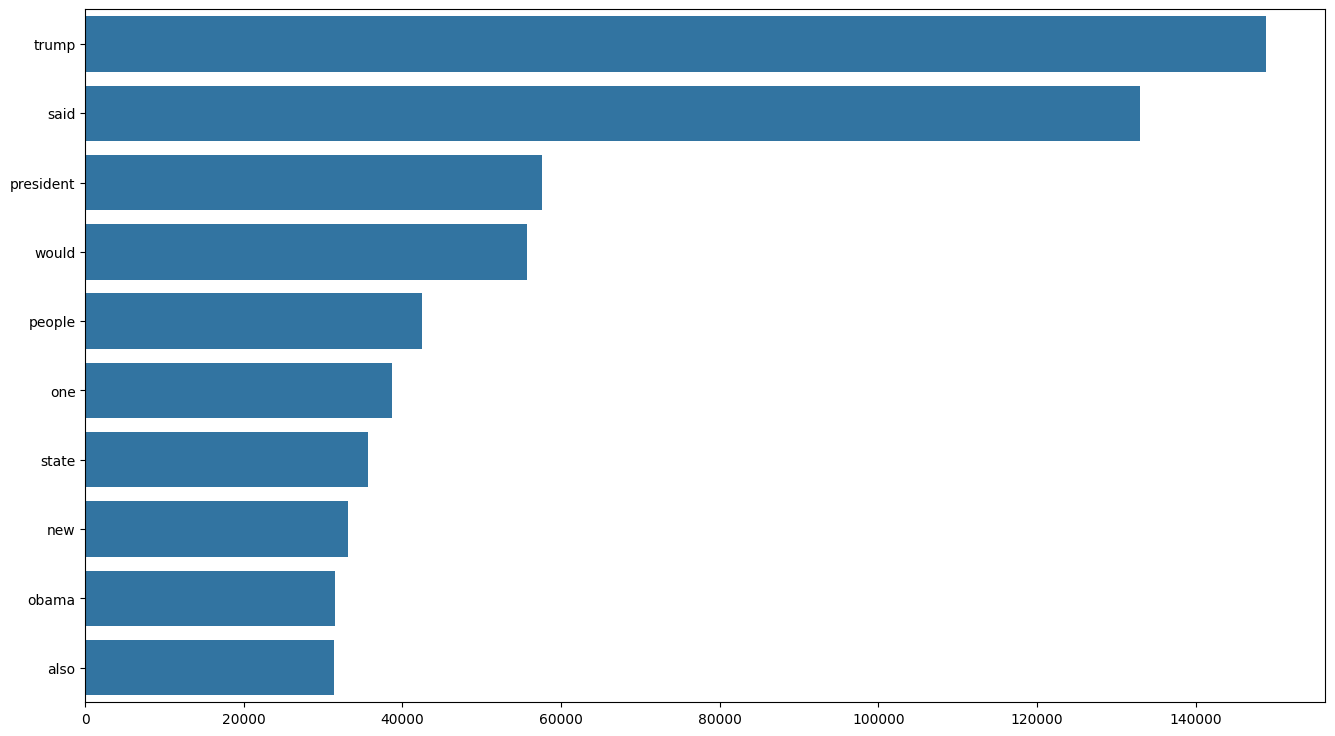

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

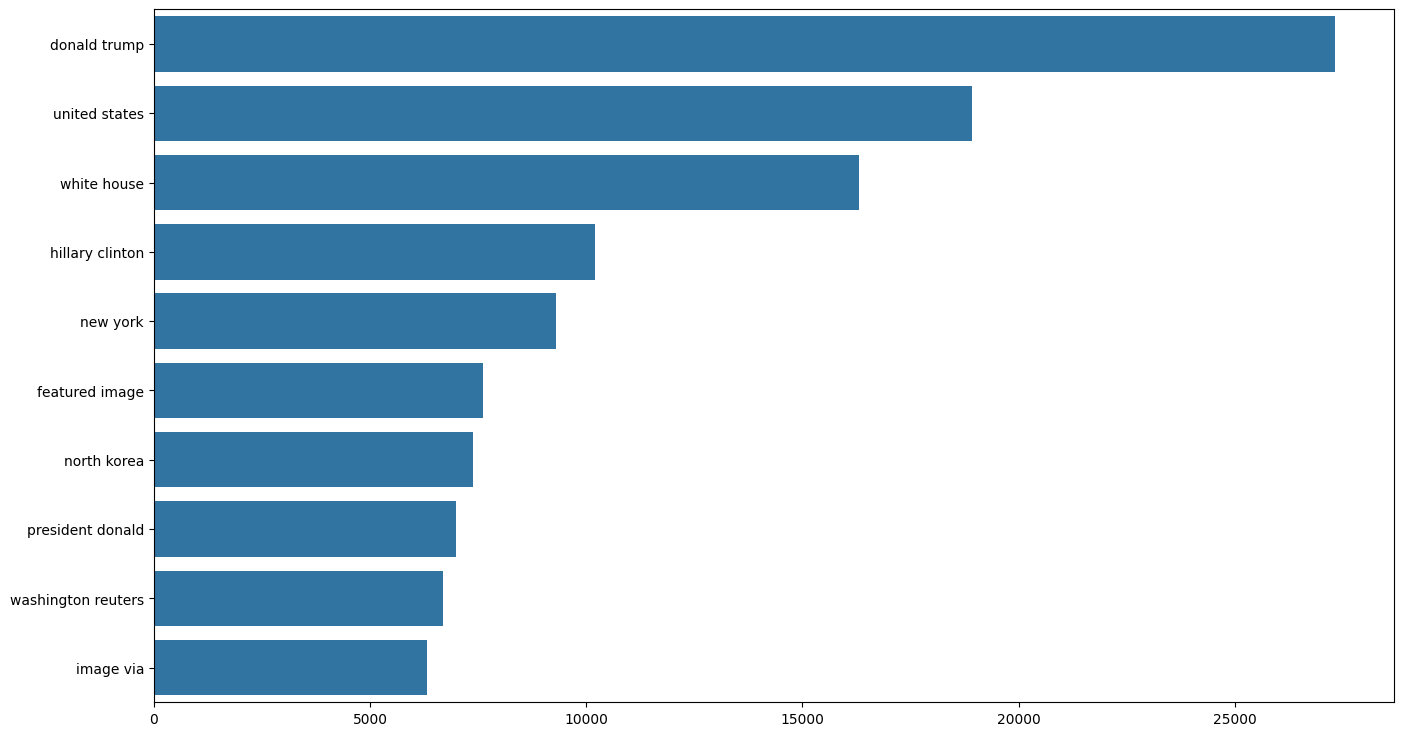

In [19]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

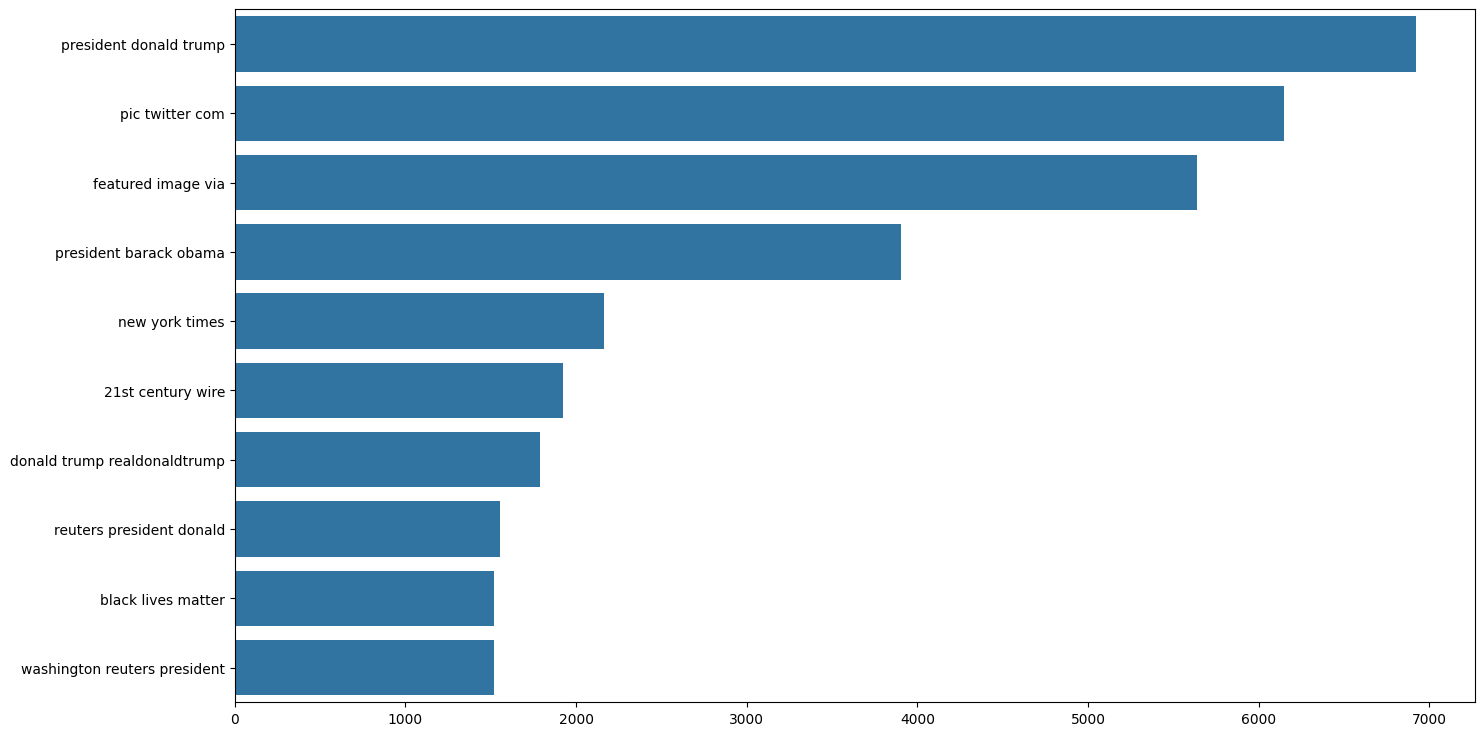

In [20]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [21]:
df.head()

,text,Category
0,tuesday president obama visited wounded ill so...,0
1,sean hannity desperation show clintons trump h...,0
2,berlin reuters german chancellor angela merkel...,1
3,washington reuters u commerce secretary wilbur...,1
4,washington reuters industry group lobbyists tu...,1


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df.text,df.Category,random_state = 0)

In [23]:
x_train.shape
x_test.shape

(11225,)

In [24]:
max_features = 10000
maxlen = 300

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen, padding='post', truncating='post')

In [26]:
print(x_train)
print(x_train.shape)

[[5912 4201  105 ...    0    0    0]
 [  15    1  138 ...    0    0    0]
 [  20   13  232 ...    0    0    0]
 ...
 [3673  140  913 ...    0    0    0]
 [2195 3907  929 ...  774   21  146]
 [   9 6623   14 ... 1556    3 2474]]
(33673, 300)


In [27]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen, padding='post', truncating='post')


In [39]:
import pickle

# After fitting tokenizer during training
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [28]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [29]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [30]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
# Change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
batch_size = 256
epochs = 10
embed_size = 100
embedding_matrix.shape

(10000, 100)

In [32]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [33]:
from keras.models import Sequential

model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix],  trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.5710 - loss: 0.6786 - val_accuracy: 0.8166 - val_loss: 0.4266 - learning_rate: 0.0100
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8871 - loss: 0.3314 - val_accuracy: 0.8939 - val_loss: 0.2660 - learning_rate: 0.0100
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.9348 - loss: 0.1666 - val_accuracy: 0.9961 - val_loss: 0.0161 - learning_rate: 0.0100
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.9958 - loss: 0.0161 - val_accuracy: 0.9986 - val_loss: 0.0075 - learning_rate: 0.0100
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9984 - val_loss: 0.0066 - learning_rate: 0.0100
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.9983 - loss: 0.0069 - val_accuracy: 0.9988 - val_loss: 0.0057 - learning_rate: 0.0100
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.9989 - loss: 0.

In [35]:
model.save('fake_new_det.keras')  # recommended


In [36]:
new_model = tf.keras.models.load_model('fake_new_det.keras')
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 300, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,506,309 (5.75 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 337,540 (1.29 MB)

In [37]:

# Load your model
model = tf.keras.models.load_model('fake_new_det.keras')

In [ ]:
import pickle

# After fitting tokenizer during training
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)